In [90]:
#Libraries
import os
import numpy as np
import keras
import hashlib
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt

In [102]:
#!unzip -q ChestCT_Scan.zip

!ls Data

test  train valid


In [103]:
!ls Data/test

adenocarcinoma          normal
large.cell.carcinoma    squamous.cell.carcinoma


In [93]:
train_dir = 'Data/train'
test_dir = 'Data/test'
valid_dir = 'Data/valid'

# Define the image size and batch size
image_size = (224, 224)
batch_size = 10

# Create a TensorFlow dataset for the test data
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size
)


train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

valid_ds = keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

Found 315 files belonging to 4 classes.
Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.


In [94]:
#Calulcating the hash value of a file 
def calculate_hash(file_path):
    with open(file_path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

    
#Find duplicates within the files     
def find_duplicate_images(directory):
    hash_to_paths = {}
    duplicate_images = []

    # Iterate over all files in the directory
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            # Calculate the hash value of the file
            file_hash = calculate_hash(file_path)
            # Check if the hash value already exists
            if file_hash in hash_to_paths:
                duplicate_images.append((file_path, hash_to_paths[file_hash]))
            else:
                hash_to_paths[file_hash] = file_path

    return duplicate_images

def remove_duplicate_images(duplicate_images):
    """Remove duplicate images from the dataset."""
    num_deleted = 0  # Initialize counter for deleted images
    for duplicate_pair in duplicate_images:
        # Remove the duplicate image file
        os.remove(duplicate_pair[0])
        num_deleted += 1  # Increment counter
    return num_deleted  # Return total number of deleted images

# Define the directory containing the images
data_dir = "Data"

# Find and remove duplicate images in the dataset
duplicate_images = find_duplicate_images(data_dir)
num_deleted = remove_duplicate_images(duplicate_images)

print(f"Deleted {num_deleted} duplicate images.")

Deleted 153 duplicate images.


In [95]:
#Checking images within the files after deletion
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=image_size,
    batch_size=batch_size,
)

train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

valid_ds = keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    seed=1337,
)

Found 283 files belonging to 4 classes.
Found 494 files belonging to 4 classes.
Found 70 files belonging to 4 classes.


In [100]:
#Limiting to 100 images per 'test' and 'training'
test_ds = test_ds.take(100)
train_ds = train_ds.take(100)

# Print the lengths of the test and train datasets
print("Number of images in the test dataset:", len(test_ds) * batch_size)
print("Number of images in the train dataset:", len(train_ds) * batch_size)

Number of images in the test dataset: 100
Number of images in the train dataset: 100


2024-04-21 13:36:59.431693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


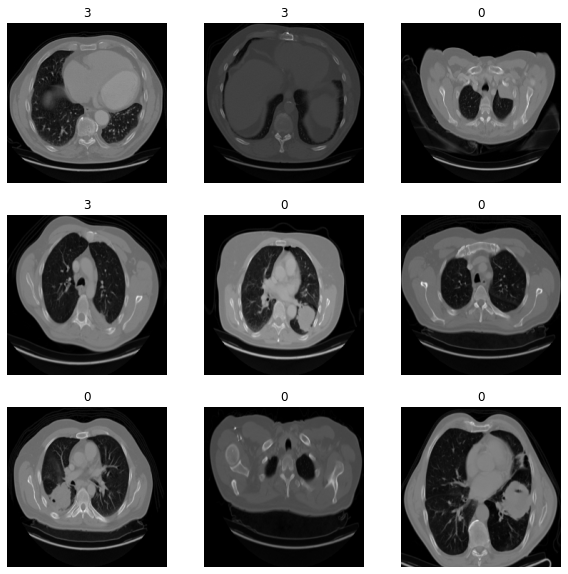

In [98]:
# Visualize a few images from the test dataset
plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):  # Take one batch of images
    for i in range(9):  # Visualize first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to numpy array and plot
        plt.title(labels[i].numpy())
        plt.axis("off")
plt.show()

2024-04-21 13:35:45.661241: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


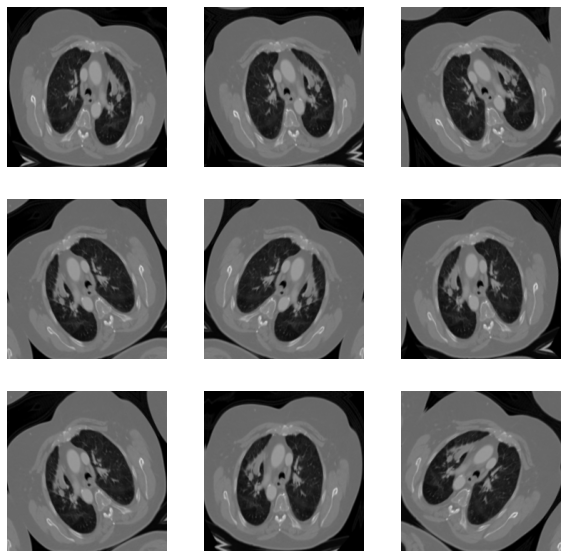

In [88]:
#Image augementation to improve model
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [99]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf_data.AUTOTUNE)

In [101]:
#DataLoader.py
def create_data_loader(train_dir, test_dir, valid_dir, image_size=(224, 224), batch_size=10):
    # Create TensorFlow datasets for the train, test, and validation data
    train_ds = keras.utils.image_dataset_from_directory(
        train_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )

    test_ds = keras.preprocessing.image_dataset_from_directory(
        test_dir,
        image_size=image_size,
        batch_size=batch_size,
    )

    valid_ds = keras.utils.image_dataset_from_directory(
        valid_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=1337,
    )

    # Calculate and remove duplicate images
    def calculate_hash(file_path):
        with open(file_path, "rb") as f:
            return hashlib.md5(f.read()).hexdigest()

    def find_duplicate_images(directory):
        hash_to_paths = {}
        duplicate_images = []

        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                file_hash = calculate_hash(file_path)
                if file_hash in hash_to_paths:
                    duplicate_images.append((file_path, hash_to_paths[file_hash]))
                else:
                    hash_to_paths[file_hash] = file_path

        return duplicate_images

    def remove_duplicate_images(duplicate_images):
        num_deleted = 0
        for duplicate_pair in duplicate_images:
            os.remove(duplicate_pair[0])
            num_deleted += 1
        return num_deleted

    data_dir = os.path.dirname(train_dir)

    duplicate_images = find_duplicate_images(data_dir)
    num_deleted = remove_duplicate_images(duplicate_images)
    print(f"Deleted {num_deleted} duplicate images.")

    # Limiting to 100 images per 'test' and 'training'
    test_ds = test_ds.take(100)
    train_ds = train_ds.take(100)

    # Image augmentation to improve model
    data_augmentation_layers = [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]

    def data_augmentation(images):
        for layer in data_augmentation_layers:
            images = layer(images)
        return images

    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(np.array(augmented_images[0]).astype("uint8"))
            plt.axis("off")

    train_ds = train_ds.map(
        lambda img, label: (data_augmentation(img), label),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
    valid_ds = valid_ds.prefetch(tf_data.AUTOTUNE)

    return train_ds, test_ds, valid_ds
